# Monitoring Roads and Speed Limits from Satellite Images using PyTorch for Image Segmentation

**Abstract**: Fine-tuning neural networks has historically been quite slow and cumbersome on CPUs. However, with mixed precision BF16 training, the Intel Extension for PyTorch has made fine-tuning training feasible on a CPU and perhaps even preferred where cost and availability are key factors. In this tutorial, I will walk you through a real-world example of training an AI image segmentation model using PyTorch 1.13.1 (with ResNet34 architecture); the model will learn to identify roads and speed limits only from satellite images, all on the newly released Intel 4th Generation CPU.

-----
Author: Ben Consolvo | Company: Intel | 
Date: March 4, 2023 <br><br>
<a href="https://discord.gg/rv2Gp55UJQo" target="Discord"> <img src="https://upload.wikimedia.org/wikipedia/en/9/98/Discord_logo.svg" width="100"/></a> <br> Please join me on Intel's Developer Discord to have further discussion. 
Invite link: https://discord.gg/rv2Gp55UJQ <br>


*You can also connect with me here*:
## <a href="https://www.linkedin.com/in/bconsolvo/" target="LinkedIn"> <img src="https://upload.wikimedia.org/wikipedia/commons/0/01/LinkedIn_Logo.svg" width="60"/></a> | <a href="https://twitter.com/bpconsolvo" target="Twitter"> <img src="https://upload.wikimedia.org/wikipedia/commons/4/4f/Twitter-logo.svg" width="25"/></a> | <a href="https://huggingface.co/bconsolvo" target=""> <img src="https://huggingface.co/front/assets/huggingface_logo-noborder.svg" width="30"/></a> | <a href="https://www.kaggle.com/bconsolvo" target="Kaggle"> <img src="https://www.kaggle.com/static/images/site-logo.svg" width="60"/></a> | <a href="https://www.quora.com/profile/Benjamin-Consolvo" target="Quora"> <img src="https://upload.wikimedia.org/wikipedia/commons/9/91/Quora_logo_2015.svg" width="40"/></a> | <a href="https://www.reddit.com/user/bconsolvo" target="Reddit"> <img src="https://upload.wikimedia.org/wikipedia/commons/b/b4/Reddit_logo.svg" width="40"/></a> | <a href="https://stackoverflow.com/users/12363294/bconsolvo" target="Stack Overflow"> <img src="https://upload.wikimedia.org/wikipedia/commons/0/02/Stack_Overflow_logo.svg" width="90"/></a> | <a href="https://www.twitch.tv/silvosjehoaddah" target="Twitch"> <img src="https://upload.wikimedia.org/wikipedia/commons/2/26/Twitch_logo.svg" width="40"/></a> |  <a href="https://github.com/bconsolvo" target="GitHub"> <img src="https://upload.wikimedia.org/wikipedia/commons/9/91/Octicons-mark-github.svg" width="25"/></a>
<br>


-----

**Introduction** <br><br>
I am excited to be able to show you today that CPUs are viable to train a deep learning model for a fine-tuning example. 

> <mark>In this tutorial, you will learn how to accelerate a PyTorch training job with Sapphire Rapids. We will use the Intel Extension for PyTorch (IPEX) library to enable built-in AI acceleration on the new Intel Xeon 4th Generation CPU (Sapphire Rapids) to work with just a couple of lines of code. You will learn how to train a satellite image with matching street labels (pixel segmentation task) example. </mark>

The potential cost savings for renting a CPU on one of the major CSPs, instead of a GPU, are significant. However, I will say that the latest CPU processors are still being rolled out to the CSPs, and it is typical for there to be a lag time to availability on the major CSPs from launch-date. 

The 4th Generation Xeon CPU I will show you today is a beast! It is being hosted on the **Intel Developer Cloud**, which you can sign up for the Beta here: [cloud.intel.com](https://cloud.intel.com). 

> Coming soon, I will provide a new tutorial around using PyTorch 2.0 after its release on March 14, 2023.

-----

**Key References** <br><br>
Much of my material and code was taken from the repository below. I've adapted it for use on the Intel 4th Generation Xeon CPU, and optimized with Intel Extension for PyTorch.
- https://github.com/avanetten/cresi 

I also highly recommend these Medium articles for another detailed explanation of how to get started with the SpaceNet5 data:
- [The SpaceNet 5 Baseline — Part 1: Imagery and Label Preparation](https://medium.com/the-downlinq/the-spacenet-5-baseline-part-1-imagery-and-label-preparation-598af46d485e)
- [The SpaceNet 5 Baseline — Part 2: Training a Road Speed Segmentation Model](https://medium.com/the-downlinq/the-spacenet-5-baseline-part-2-training-a-road-speed-segmentation-model-2bc93de564d7)
- [The SpaceNet 5 Baseline — Part 3: Extracting Road Speed Vectors from Satellite Imagery](https://medium.com/the-downlinq/the-spacenet-5-baseline-part-3-extracting-road-speed-vectors-from-satellite-imagery-5d07cd5e1d21)

I also referenced 2 Hugging Face blogs by Julien Simon here. He ran his tests on the AWS instance `r7iz.metal-16xl` :
- [Accelerating PyTorch Transformers with Intel Sapphire Rapids, part 1](https://huggingface.co/blog/intel-sapphire-rapids)
- [Accelerating PyTorch Transformers with Intel Sapphire Rapids, part 2](https://huggingface.co/blog/intel-sapphire-rapids-inference)

-----
**Intel Xeon 4th Generation CPU Specs (Bare Metal)**
- 2 sockets
- 56 physical cores (112 vCPUs) per socket
- 224 vCPUs total
- 500 GB of memory
- Advanced Matrix Extensions:
    - New Intel® Advanced Matrix Extensions (Intel® AMX), a built-in AI acceleration engine.

Operating System:
- Ubuntu 22.04

Key Software: 
- Intel Extension for PyTorch ([GitHub link](https://github.com/intel/intel-extension-for-pytorch))

Model Architecture:
- ResNet34

In [133]:
!lscpu 

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         52 bits physical, 57 bits virtual
  Byte Order:            Little Endian
CPU(s):                  224
  On-line CPU(s) list:   0-223
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Xeon(R) Platinum 8480+
    CPU family:          6
    Model:               143
    Thread(s) per core:  2
    Core(s) per socket:  56
    Socket(s):           2
    Stepping:            8
    CPU max MHz:         3800.0000
    CPU min MHz:         800.0000
    BogoMIPS:            4000.00
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mc
                         a cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss 
                         ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art
                          arch_perfmon pebs bts rep_good nopl xtopology nonstop_
                         tsc cpuid aperfmperf tsc_known_freq pni pclmulqdq dtes6
   

#### Flags for AMX
Under "flags", you can see `amx_bf16`, `amx_tile`, and `amx_int8`, so you know AMX is available for use.

# Environment setup
The environment setup will depend on what already comes installed on the machine you are using, but here is a guide on what I did, using a 4th Generation Xeon CPU from [cloud.intel.com](https://cloud.intel.com). To simplify the environment setup, I built short bash scripts that can be run from the command line to build out your environment. Please note that you may need to make adjustments depending on the build and configuration of your machine.

0. **Building backend software with `apt-get`** <br>
Building apt-get packages that support libraries later installed by `conda` or `pip`.
```bash
#Fix broken installs for apt-get
sudo apt-get --fix-broken install

#Update apt-get
sudo apt-get update
sudo apt-get autoremove

#Install packages
sudo apt-get install -y \
    cdo \
    nco \
    gdal-bin \
    libgdal-dev \
    libjemalloc-dev \
    awscli \
    cmake \
    apt-utils \
    python3-dev \
    libssl-dev \
    libffi-dev \
    libncurses-dev \
    libgl1 \
    ffmpeg \
    libsm6 \
    libxext6
```



1. **Setting up Anaconda environment** <br>
Building Anaconda environment and installing some packages with `conda install`.
```bash
#Download and install Miniconda distribution of Anaconda
wget https://repo.anaconda.com/miniconda/Miniconda3-py38_23.1.0-1-Linux-x86_64.sh -O ~/miniconda.sh && \
    sudo /bin/bash ~/miniconda.sh -b -p /opt/conda && \
    rm ~/miniconda.sh && \
    /opt/conda/bin/conda clean -tip && \
    sudo ln -s /opt/conda/etc/profile.d/conda.sh /etc/profile.d/conda.sh && \
    echo ". /opt/conda/etc/profile.d/conda.sh" >> ~/.bashrc && \
source ~/.bashrc
#Create new conda environment
conda create --name py39 python=3.9
echo "conda activate py39" >> ~/.bashrc
source ~/.bashrc

pip3 install setuptools==57.5.0 #for gdal3.0.4 to work

conda install -c conda-forge libgdal
conda install -c conda-forge gdal=3.0.4
conda install tiledb=2.2
conda install poppler
conda install intel-openmp
```

2. **Installing pip packages** <br>
Installing PyTorch for CPU, as well as a `requirements.txt` file of packages
```bash
#pip upgrades
python -m pip install --upgrade pip wheel

#install torch for CPU
pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu

#install requirements packages
pip3 install -r requirements.txt

#put the newly created conda environment into Jupyter
python -m ipykernel install --user --name=py39

#install oneCCL if want to launch more complicated (distributed) jobs
#python -m pip install oneccl_bind_pt==1.13 -f https://developer.intel.com/ipex-whl-stable-cpu
```
The `requirements.txt` is:
```
scikit-image
jupyterlab 
ipykernel
numpy
pandas
scipy
matplotlib
fiona
opencv-python
shapely
imagecodecs
tqdm
osmnx
torchsummary
geopandas==0.6.3
tensorboardX
tensorboard
networkx==2.8
numba
utm
intel_extension_for_pytorch
```

3. **Cloning cresi repository** <br>
The cresi repository contains a lot of the code needed to run training and inference in this demo.
```bash
git clone https://github.com/avanetten/cresi
```

4. **Downloading SpaceNet 5 data** <br>
For this tutorial we will use public imagery from the [SpaceNet 5 Challenge](https://spacenet.ai/sn5-challenge/).  These weights and images are are part of the [Registry of Open Data on AWS](https://registry.opendata.aws/spacenet/), and can be downloaded for free.  You will need an AWS account to access the data, and the AWS CLI tool installed. Then, simply execute `aws configure` from the command line and input your **AWS Access Key ID** and your **AWS Secret Access Key**. Once this is set up, you should be able to download the dataset directly from the public S3 bucket below. Then, you can run this script to download the data:

```bash
#download and unzip moscow data
aws s3 cp s3://spacenet-dataset/spacenet/SN5_roads/tarballs/SN5_roads_train_AOI_7_Moscow.tar.gz ~/spacenet5data/moscow/.
tar -xvzf ~/spacenet5data/moscow/SN5_roads_train_AOI_7_Moscow.tar.gz ~/spacenet5data/moscow/data/.

#download and unzip mumbai data
aws s3 cp s3://spacenet-dataset/spacenet/SN5_roads/tarballs/SN5_roads_train_AOI_8_Mumbai.tar.gz .
tar -xvzf SN5_roads_train_AOI_8_Mumbai.tar.gz
```
5. **Launching Jupyter Labs** <br>
I have some instructions for launching Jupyter Lab on the Intel Developer Cloud instance, and then how you would connect in from your local machine on a web browser. After you have installed Jupyter Lab from the previous steps, from the command line, you can launch a Jupyter server.  I prefer to do this in a `tmux` window, so that I can exit out still use the same terminal window. You can read more about [tmux here on their GitHub](https://github.com/tmux/tmux/wiki). You can use the provided script:
```bash
jupyter lab --port=8080 --ServerApp.ip=* --no-browser
```
In order to be able to connect to the Jupyter server on a local browser, you can create an SSH tunnel with a command like the following in a different terminal window (connecting your local machine to the remote machine):
```bash
ssh -J guest@146.152.226.42 -L 8080:localhost:8080 devcloud@192.168.19.2
```
You should now be able to go to a local browser and enter the URL below to access your Jupyter server <br>
https://localhost:8080

In [28]:
#Command to show how much room you have available on disk
!df -h

Filesystem      Size  Used Avail Use% Mounted on
tmpfs            51G  4.0M   51G   1% /run
/dev/nvme0n1p2  6.9T  136G  6.4T   3% /
tmpfs           252G  2.1G  250G   1% /dev/shm
tmpfs           5.0M     0  5.0M   0% /run/lock
/dev/nvme0n1p1  537M  5.3M  532M   1% /boot/efi
tmpfs            51G  4.0K   51G   1% /run/user/1000


# Python Package Imports for Notebook

In [67]:
#importing packages
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import json
import pandas as pd

%load_ext autoreload
%autoreload 2

# Image Dataset Preparation - Making Masks

The images have names like the following: `SN5_roads_train_AOI_7_Moscow_PS-RGB_chip180.tif` <br>
`SN5` means SpaceNet 5 <br>
`PS-MS` means pan-sharpened (PS) 8-band multispectral (MS) image <br>
`PS-RGB` means pan-sharpened (PS) 3-band RGB image <br>

The 8-band multispectral images are of shape `(1300,1300,8)`, whereas the RGB images are of shape `(1300,1300,3)`. Here in the notebook I only show the 3-channel RGB images, but feel free to explore ways to visualize the 8-band images.


Each "clip" of a satellite image has corresponding labels of where the streets are located. We need will teach a neural network about, so it can predict where streets are based on the satellite image alone. 


> After unzipping the `SN5_roads_train_AOI_7_Moscow.tar.gz` file, you should find the `geojson_roads_speed` folder within each area of interest (AOI) directory (`nfs/data/cosmiq/spacenet/competitions/SN5_roads/tiles_upload/train/AOI_7_Moscow/geojson_roads_speed`). It contains road centerline labels along with estimates of safe travel speeds for each roadway.  We'll use these centerline labels and speed estimates to create training masks. We assume a mask buffer of 2 meters, meaning that each roadway is assigned a total width of 4 meters.  Remember that the goal of our segmentation step is to detect road centerlines, so while this is not the precise width of the road, a buffer of 2 meters is an appropriate width for our segmentation model.

> One option for training a segmentation model is to create training masks where the value of the mask is proportional to the speed of the roadway. This can be accomplished by running the `speed_masks.py` script (https://github.com/avanetten/cresi/blob/main/cresi/data_prep/speed_masks.py).
```
!python3 /home/devcloud/cresi/cresi/data_prep/speed_masks.py --geojson_dir=/home/devcloud/spacenet5data/moscow/data/geojson_roads_speed \
        --image_dir=/home/devcloud/spacenet5data/moscow/data/PS-MS \
        --output_conversion_csv_binned=/home/devcloud/spacenet5data/moscow/data/v6/output_conversion_csv_binned/sn5_roads_train_speed_conversion_binned.csv \
        --output_mask_dir=/home/devcloud/spacenet5data/moscow/data/v6/train_mask_binned \
        --output_mask_multidim_dir=/home/devcloud/spacenet5data/moscow/data/v6/train_mask_binned_mc \
        --buffer_distance_meters=2 \
        --crs=None
```
**Displaying Satellite Images and Corresponding Image Masks** <br>
Below, I am showing a sample of some of the satellite images in RGB format (each image is an array of shape (1300,1300,3), where 1300x1300 is the pixel count, and 3 are the three R-G-B color channels.

The generated mask images are the corresponding masks to these specific clips. The different colors of the roads indicate different speed limits.

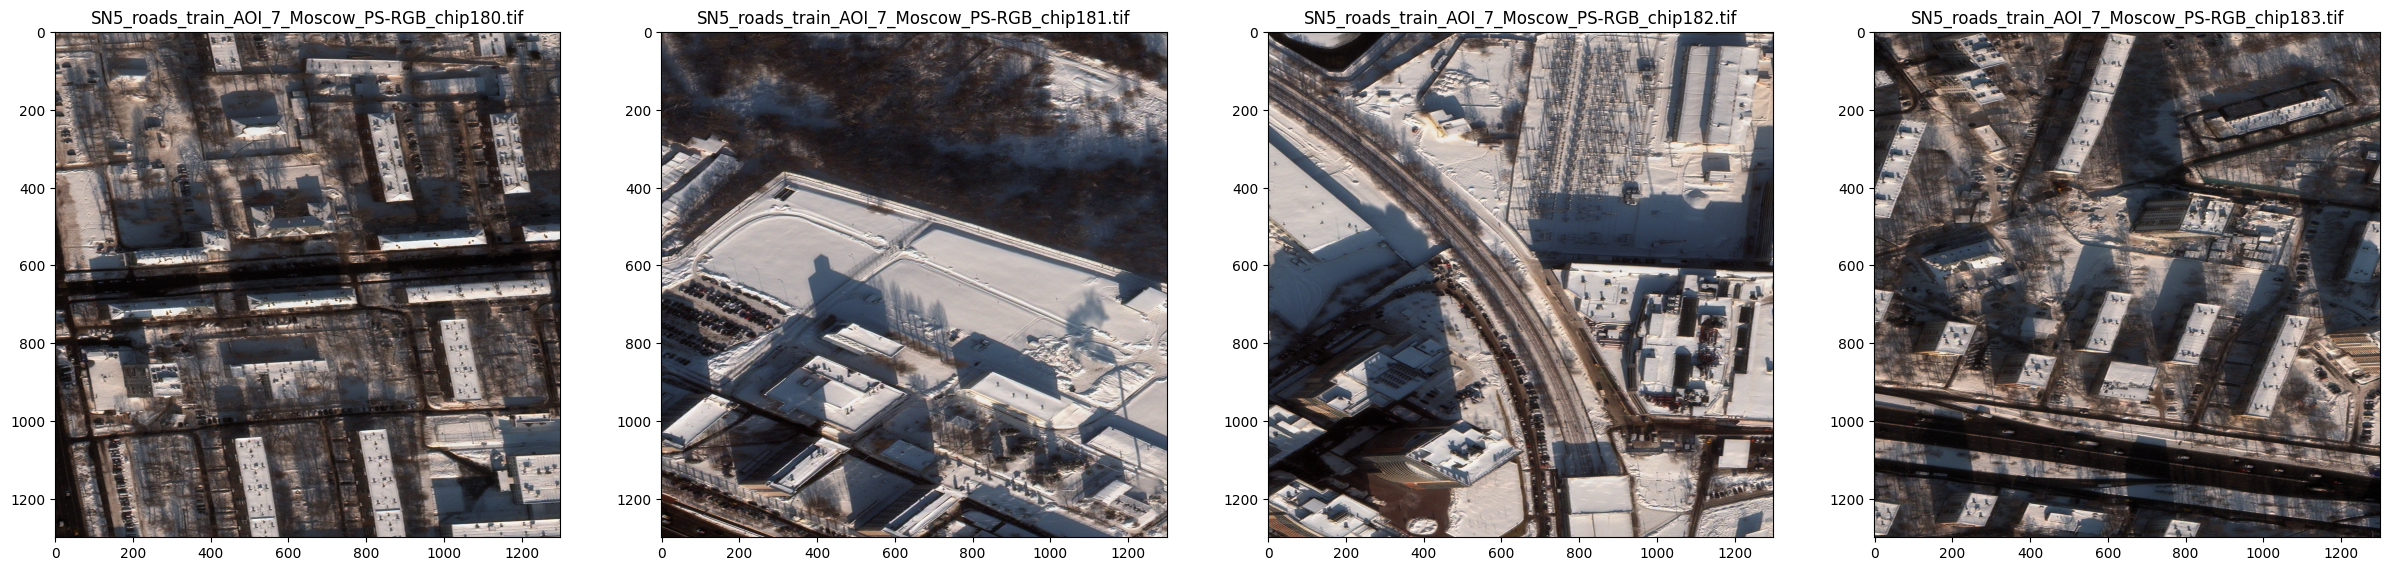

Image array shape is (1300, 1300, 3)


In [57]:
#Showing some sample images
image_dir = '/home/devcloud/spacenet5data/moscow/data/PS-RGB' #replace with your local path to the images
image_names = ['SN5_roads_train_AOI_7_Moscow_PS-RGB_chip180.tif',
               'SN5_roads_train_AOI_7_Moscow_PS-RGB_chip181.tif',
               'SN5_roads_train_AOI_7_Moscow_PS-RGB_chip182.tif',
               'SN5_roads_train_AOI_7_Moscow_PS-RGB_chip183.tif']
full_path_images = [Path(image_dir,img) for img in image_names]

fig = plt.figure(figsize=(30, 10))
columns = 4
rows = 1
ax = []
for idx,num in enumerate(range(columns*rows)):
    img = skimage.io.imread(full_path_images[idx])
    ax.append(fig.add_subplot(rows,columns,num+1))
    ax[-1].set_title(image_names[idx])
    plt.imshow(img)
plt.show()
print(f'Image array shape is {img.shape}')

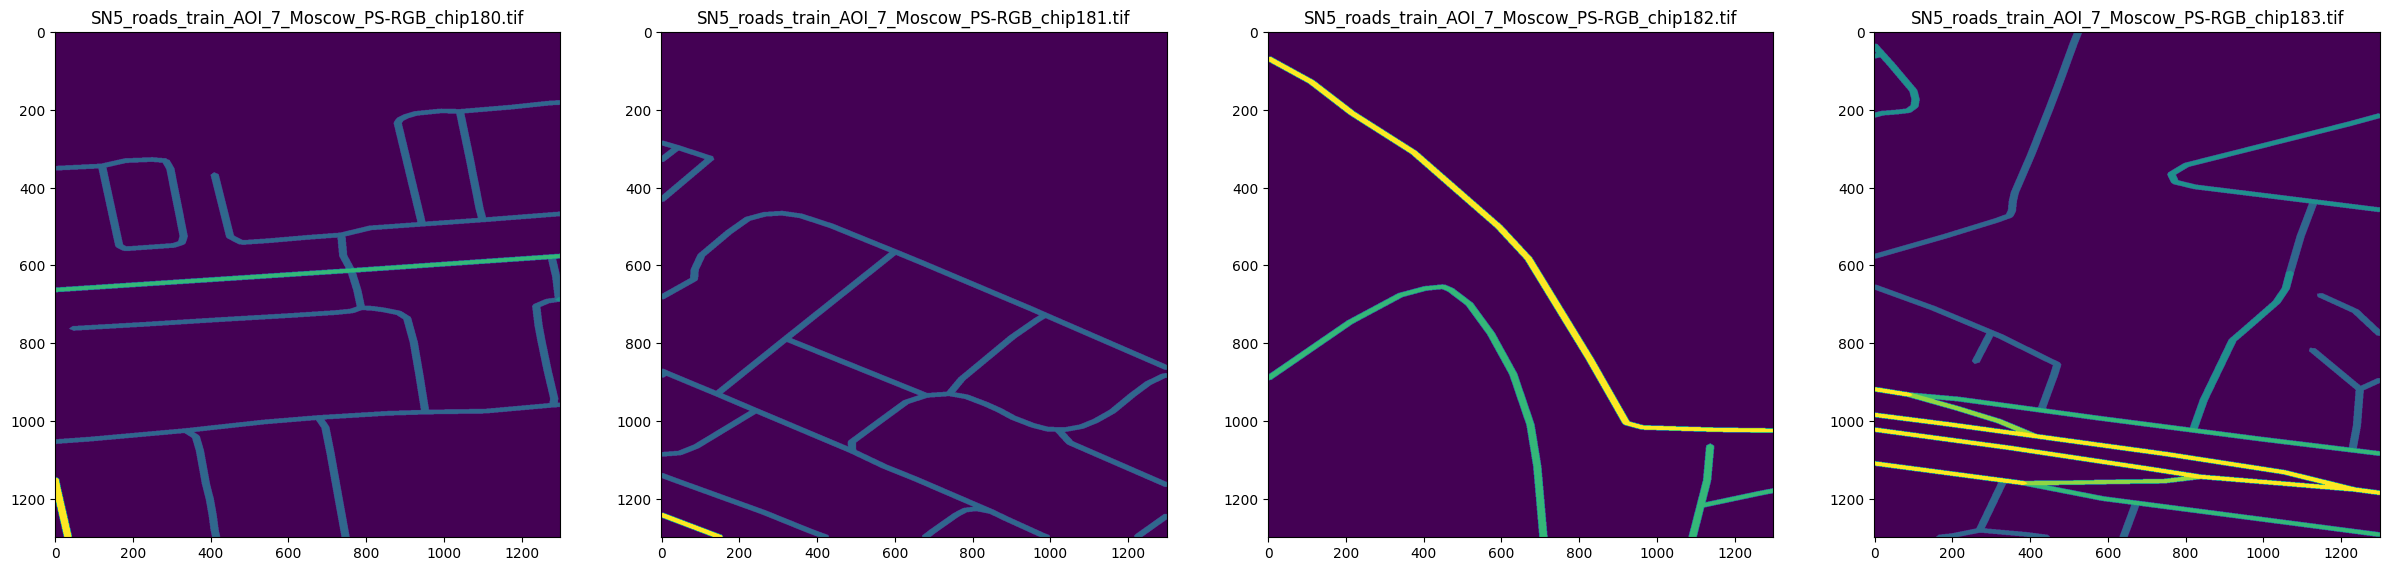

Image array shape is (1300, 1300)


In [58]:
#Showing some sample images
image_dir = '/home/devcloud/spacenet5data/moscow/data/v5/train_mask_binned_rename_rgb' #replace with your local path to the images
image_names = ['SN5_roads_train_AOI_7_Moscow_PS-RGB_chip180.tif',
               'SN5_roads_train_AOI_7_Moscow_PS-RGB_chip181.tif',
               'SN5_roads_train_AOI_7_Moscow_PS-RGB_chip182.tif',
               'SN5_roads_train_AOI_7_Moscow_PS-RGB_chip183.tif']
full_path_images = [Path(image_dir,img) for img in image_names]

fig = plt.figure(figsize=(30, 10))
columns = 4
rows = 1
ax = []
for idx,num in enumerate(range(columns*rows)):
    img = skimage.io.imread(full_path_images[idx])
    ax.append(fig.add_subplot(rows,columns,num+1))
    ax[-1].set_title(image_names[idx])
    plt.imshow(img)
plt.show()
print(f'Image array shape is {img.shape}')

# Training Configuration Prep

**Building Configuration JSON for train/validation split and training parameters** <br>
First, we need to build a JSON configuration file that defines how we will split up the image data into training and validation sets, and define our training parameters. The location of the default configuration file should be found in your cloned cresi directory. You can find a sample config here: <br> https://github.com/avanetten/cresi/blob/main/cresi/configs/sn5_baseline_aws.json. <br><br>
My edited config file looks like:
```python
{
    "path_src": "/home/devcloud/cresi/cresi",
    "path_results_root": "/home/devcloud/spacenet5data/moscow/results_xeon4_devcloud", 
    "train_data_refined_dir_ims": "/home/devcloud/spacenet5data/moscow/data/PS-MS",
    "train_data_refined_dir_masks": "/home/devcloud/spacenet5data/moscow/data/v5/train_mask_binned_mc",
    "speed_conversion_file": "/home/devcloud/spacenet5data/moscow/data/v5/output_conversion_csv_binned/sn5_roads_train_speed_conversion_binned.csv",
    "folds_file_name": "folds4.csv",
    "save_weights_dir": "sn5_baseline",
    "num_folds": 1,
    "default_val_perc": 0.2,
    "num_channels": 8,
    "num_classes": 8,
    "network": "resnet34",
    "loss": {
        "soft_dice": 0.25,
        "focal": 0.75
    },
    "early_stopper_patience": 8,
    "nb_epoch": 30,
    "test_data_refined_dir": "/home/devcloud/spacenet5data/moscow/data/PS-MS",
    "test_results_dir": "sn5_baseline",
    "folds_save_dir": "folds",
    "tile_df_csv": "tile_df.csv",
    "test_sliced_dir": "",
    "slice_x": 0,
    "slice_y": 0,
    "stride_x": 0,
    "stride_y": 0,
    "skeleton_band": 7,
    "skeleton_thresh": 0.3,
    "min_subgraph_length_pix": 20,
    "min_spur_length_m": 10,
    "GSD": 0.3,
    "rdp_epsilon": 1,
    "log_to_console": 1,
    "intersection_band": -1,
    "use_medial_axis": 0,
    "merged_dir": "merged",
    "stitched_dir_raw": "stitched/mask_raw",
    "stitched_dir_count": "stitched/mask_count",
    "stitched_dir_norm": "stitched/mask_norm",
    "wkt_submission": "wkt_submission_nospeed.csv",
    "skeleton_dir": "skeleton",
    "skeleton_pkl_dir": "sknw_gpickle",
    "graph_dir": "graphs",
    "padding": 22,
    "eval_rows": 1344,
    "eval_cols": 1344,
    "batch_size": 33,
    "iter_size": 1,
    "lr": 0.0001,
    "lr_steps": [
        20,
        25
    ],
    "lr_gamma": 0.2,
    "test_pad": 64,
    "epoch_size": 8,
    "predict_batch_size": 33,
    "target_cols": 512,
    "target_rows": 512,
    "optimizer": "adam",
    "warmup": 0,
    "ignore_target_size": false
}
```

Code to load JSON into Jupyter:
```python
training_config = '/home/devcloud/cresi/cresi/configs/ben/v5_sn5_baseline_ben.json'
f = open(training_config)
obj = json.load(f)
print(json.dumps(obj, indent=4))
```

Here are a few elaborations on some of these parameters: <br>

| parameter | description | 
| --------- | ---------- | 
| `path_src` | directory to local clone of cresi repository folder | 
| `path_results_root` | directory where all results are saved, including the split of training and test data, and trained model weights. | 
| `train_data_refined_dir_ims` | directory where all of the training images reside. For example, `SN5_roads_train_AOI_7_Moscow_PS-MS_chip1241.tif` is one of the images in this directory. |
| `train_data_refined_dir_masks` | directory where the corresponding masks reside. These images are generated with the `speed_masks.py` script referenced earlier. The images should have the exact same name as the training images. | 
| `speed_conversion_file` | path to the binned speed conversion CSV file. It should have 3 columns and look like: `burn_val,speed,channel` with the first line looking like `36,1,0`. Speeds are in miles per hour, and there are 7 possible output channels for speeds, and the 8th channel is an aggregate of the rest. |
| `folds_file_name` | This file will be saved in the `path_results_root` / `weights` / `save_weights_dir` directory. It is simply a list of the image file names, along with which fold number. `SN5_roads_train_AOI_7_Moscow_PS-MS_chip379.tif,0`. If the fold number is 0 in our case, it is part of the validation set.
| `save_weights_dir` | Directory where model weights are saved in `path_results_root` / `weights` path. 
| `num_folds` | Number of validation fold datasets. "Using multiple cross-validated models can improve performance, though at the expense of increased run time at inference. For our baseline we use only a single fold, and randomly withhold 20% of the data for validation purposes during training. We use this validation data to test performance after each epoch, and truncate training if the validation loss does not decrease for 8 epochs." ([Source](https://medium.com/the-downlinq/the-spacenet-5-baseline-part-2-training-a-road-speed-segmentation-model-2bc93de564d7)) |
| `default_val_perc` | Percentage of data for validation during training. | 
| `num_channels` | The number of channels in the training image. For PS-MS pan-sharpened (PS) 8-band multispectral (MS) images, you can put 8. If using PS-RGB pan-sharpened (PS) 3-band RGB images, you can put 3. | 
| `num_classes` | Number of bins of speed limits. In our case, we have binned the data into 8 speed limit buckets. | 
| `network` | Neural network architecture. Choices at the time of writing are: `resnet34`, `resnet50`, `resnet101`,`seresnet50`,`seresnet101`,`seresnet152`, `seresnext50`, or `seresnext101`. The choice of model architecture will influence the speed and accuracy of training. | 
| `loss` | Type of loss function. "Custom loss function comprised of 25% Dice Loss and 75% Focal Loss." ([Source](https://medium.com/the-downlinq/the-spacenet-5-baseline-part-2-training-a-road-speed-segmentation-model-2bc93de564d7)) | 
| `nb_epoch` | Number of epochs | 
| `batch_size` | Number of images to use in one batch to load into memory. Note that this can be increased or decreased depending on your memory requirements. |  
| `optimizer` | Optimizers at the time of writing that can be chosen are: `adam`, `rmsprop`, and `sgd`. | 

There are numerous other configuration parameters that can be adjusted for training time and inference time, but we will leave those alone.

**Creating Validation Fold** <br>
We need to create the validation fold of data. To do that, we can use the `00_gen_folds.py` script (https://github.com/avanetten/cresi/blob/main/cresi/00_gen_folds.py) with the previously configured parameter file. For example, I ran:
```
!python3 /home/devcloud/cresi/cresi/00_gen_folds.py /home/devcloud/cresi/cresi/configs/ben/v5_sn5_baseline_ben.json
```
The output is a folds CSV file: `/home/devcloud/spacenet5data/moscow/results_xeon4_devcloud/weights/sn5_baseline/folds4.csv`

There are folds 0, 1, 2, 3, and 4. The validation data are fold 0 (20%), and the training data are folds 1-4 (80%).

In [3]:
folds = '/home/devcloud/spacenet5data/moscow/results_xeon4_devcloud/weights/sn5_baseline/folds4.csv'
pd.read_csv(folds)

Unnamed: 0  fold
0      SN5_roads_train_AOI_7_Moscow_PS-MS_chip379.tif     0
1      SN5_roads_train_AOI_7_Moscow_PS-MS_chip932.tif     1
2      SN5_roads_train_AOI_7_Moscow_PS-MS_chip210.tif     2
3      SN5_roads_train_AOI_7_Moscow_PS-MS_chip305.tif     3
4     SN5_roads_train_AOI_7_Moscow_PS-MS_chip1273.tif     4
...                                               ...   ...
1348  SN5_roads_train_AOI_7_Moscow_PS-MS_chip1243.tif     3
1349   SN5_roads_train_AOI_7_Moscow_PS-MS_chip810.tif     4
1350   SN5_roads_train_AOI_7_Moscow_PS-MS_chip538.tif     0
1351   SN5_roads_train_AOI_7_Moscow_PS-MS_chip172.tif     1
1352  SN5_roads_train_AOI_7_Moscow_PS-MS_chip1318.tif     2

[1353 rows x 2 columns]

### Codebase Changes


I had to make some minor code changes to the `cresi` repo, described below, in order to run with the new Intel CPU with AMX.
***

1. **Make sure that the code runs natively on a CPU, instead of a GPU.**
    - In https://github.com/avanetten/cresi/blob/main/cresi/net/pytorch_utils/train.py: 
        - Replace `self.model = nn.DataParallel(model).cuda()` with `self.model = nn.DataParallel(model)`
    - In https://github.com/avanetten/cresi/blob/main/cresi/01_train.py:
        - Remove `torch.randn(10).cuda()`

***

2. **Optimize the training code with Intel Extension for PyTorch, to get the most benefit out of training on a CPU.**
    - In https://github.com/avanetten/cresi/blob/main/cresi/net/pytorch_utils/train.py:
        - Add `import intel_extension_for_pytorch as ipex` with the import statements
        - Add line for IPEX optimization and bfloat16 for mixed precision training just after defining the model and optimizer: 
        
            ```python
            self.model = nn.DataParallel(model) #.cuda() only for GPU
            self.optimizer = optimizer(self.model.parameters(), lr=config.lr)
            ```
            `self.model, self.optimizer = ipex.optimize(self.model, optimizer=self.optimizer,dtype=torch.bfloat16)`
        - Add a line to do mixed precision on CPU just before running a forward pass and calculating the loss function:
            
            `with torch.cpu.amp.autocast():`
            ```python
                if verbose:
                    print("input.shape, target.shape:", input.shape, target.shape)
                output = self.model(input)
                meter = self.calculate_loss_single_channel(output, target, meter, training, iter_size)
            ```
***
3. **Optimize inference code with Intel Extension for PyTorch**
    - In https://github.com/avanetten/cresi/blob/main/cresi/net/pytorch_utils/eval.py:
        - Add `import intel_extension_for_pytorch as ipex` in the imports
        - After loading the PyTorch model, use IPEX to optimize the model for bfloat16 inference
            ```python
            model = torch.load(os.path.join(path_model_weights, 'fold{}_best.pth'.format(fold)),  map_location=lambda storage, loc: storage)
            model.eval()
            ```
            `model = ipex.optimize(model,dtype=torch.bfloat16)`
        - Just prior to running prediction on the data, add 2 lines to do mixed precision on CPU:
            ```python 
            with torch.no_grad():
                with torch.cpu.amp.autocast():
                    for data in pbar:
                        samples = torch.autograd.Variable(data['image'], volatile=True)
                        predicted = predict(model, samples, flips=self.flips)  
            ```    

***

4. **Replace outdated torch code.**
    - In https://github.com/avanetten/cresi/blob/main/cresi/net/pytorch_utils/loss.py: 
        - Replace all of the outdated `.view` functions with `.reshape`. 
    - In https://github.com/avanetten/cresi/blob/main/cresi/net/pytorch_utils/train.py:
        - Replace all `F.sigmoid` (or `torch.nn.functional.sigmoid`) with `torch.sigmoid`
        - Replace all `.clip_grad_norm` with `.clip_grad_norm_`
        - Replace `self.estimator.lr_scheduler.step(epoch)` with `self.estimator.lr_scheduler.step()`
        - Remove the following lines entirely, as `autograd` is no longer needed:
            - `input = torch.autograd.Variable(input.cuda(async=True), volatile=not training)`
            - `target = torch.autograd.Variable(target.cuda(async=True), volatile=not training)`

# Begin Training ResNet34
Let's recap. We have:
- Created speed-limit image masks to correspond to our training satellite image data
- Defined our configuration file for training
- Split up our training and validation data
- Optimized our code for CPU

We now can begin our training run with the `01_train.py` script (original here: https://github.com/avanetten/cresi/blob/main/cresi/01_train.py). As noted above, I did make some modifications to complete the training on an Intel Xeon CPU with AMX, and to use mixed precision training with BF16.
```
!python /home/devcloud/cresi/cresi/01_train.py /home/devcloud/cresi/cresi/configs/ben/v5_sn5_baseline_ben.json --fold=0
```

**During Training Run** <br>
During training, you can launch TensorBoard with the appropriate log directory to monitor the loss function progress over time:
```
tensorboard --logdir /home/devcloud/spacenet5data/moscow/results_xeon4_devcloud/logs/sn5_baseline/fold0 --port 8090
```
And then you can create another SSH tunnel:
```
ssh -J guest@146.152.226.42 -L 8090:localhost:8090 devcloud@192.168.19.2
```
and launch in your local browser at https://localhost:8090. It should look like:

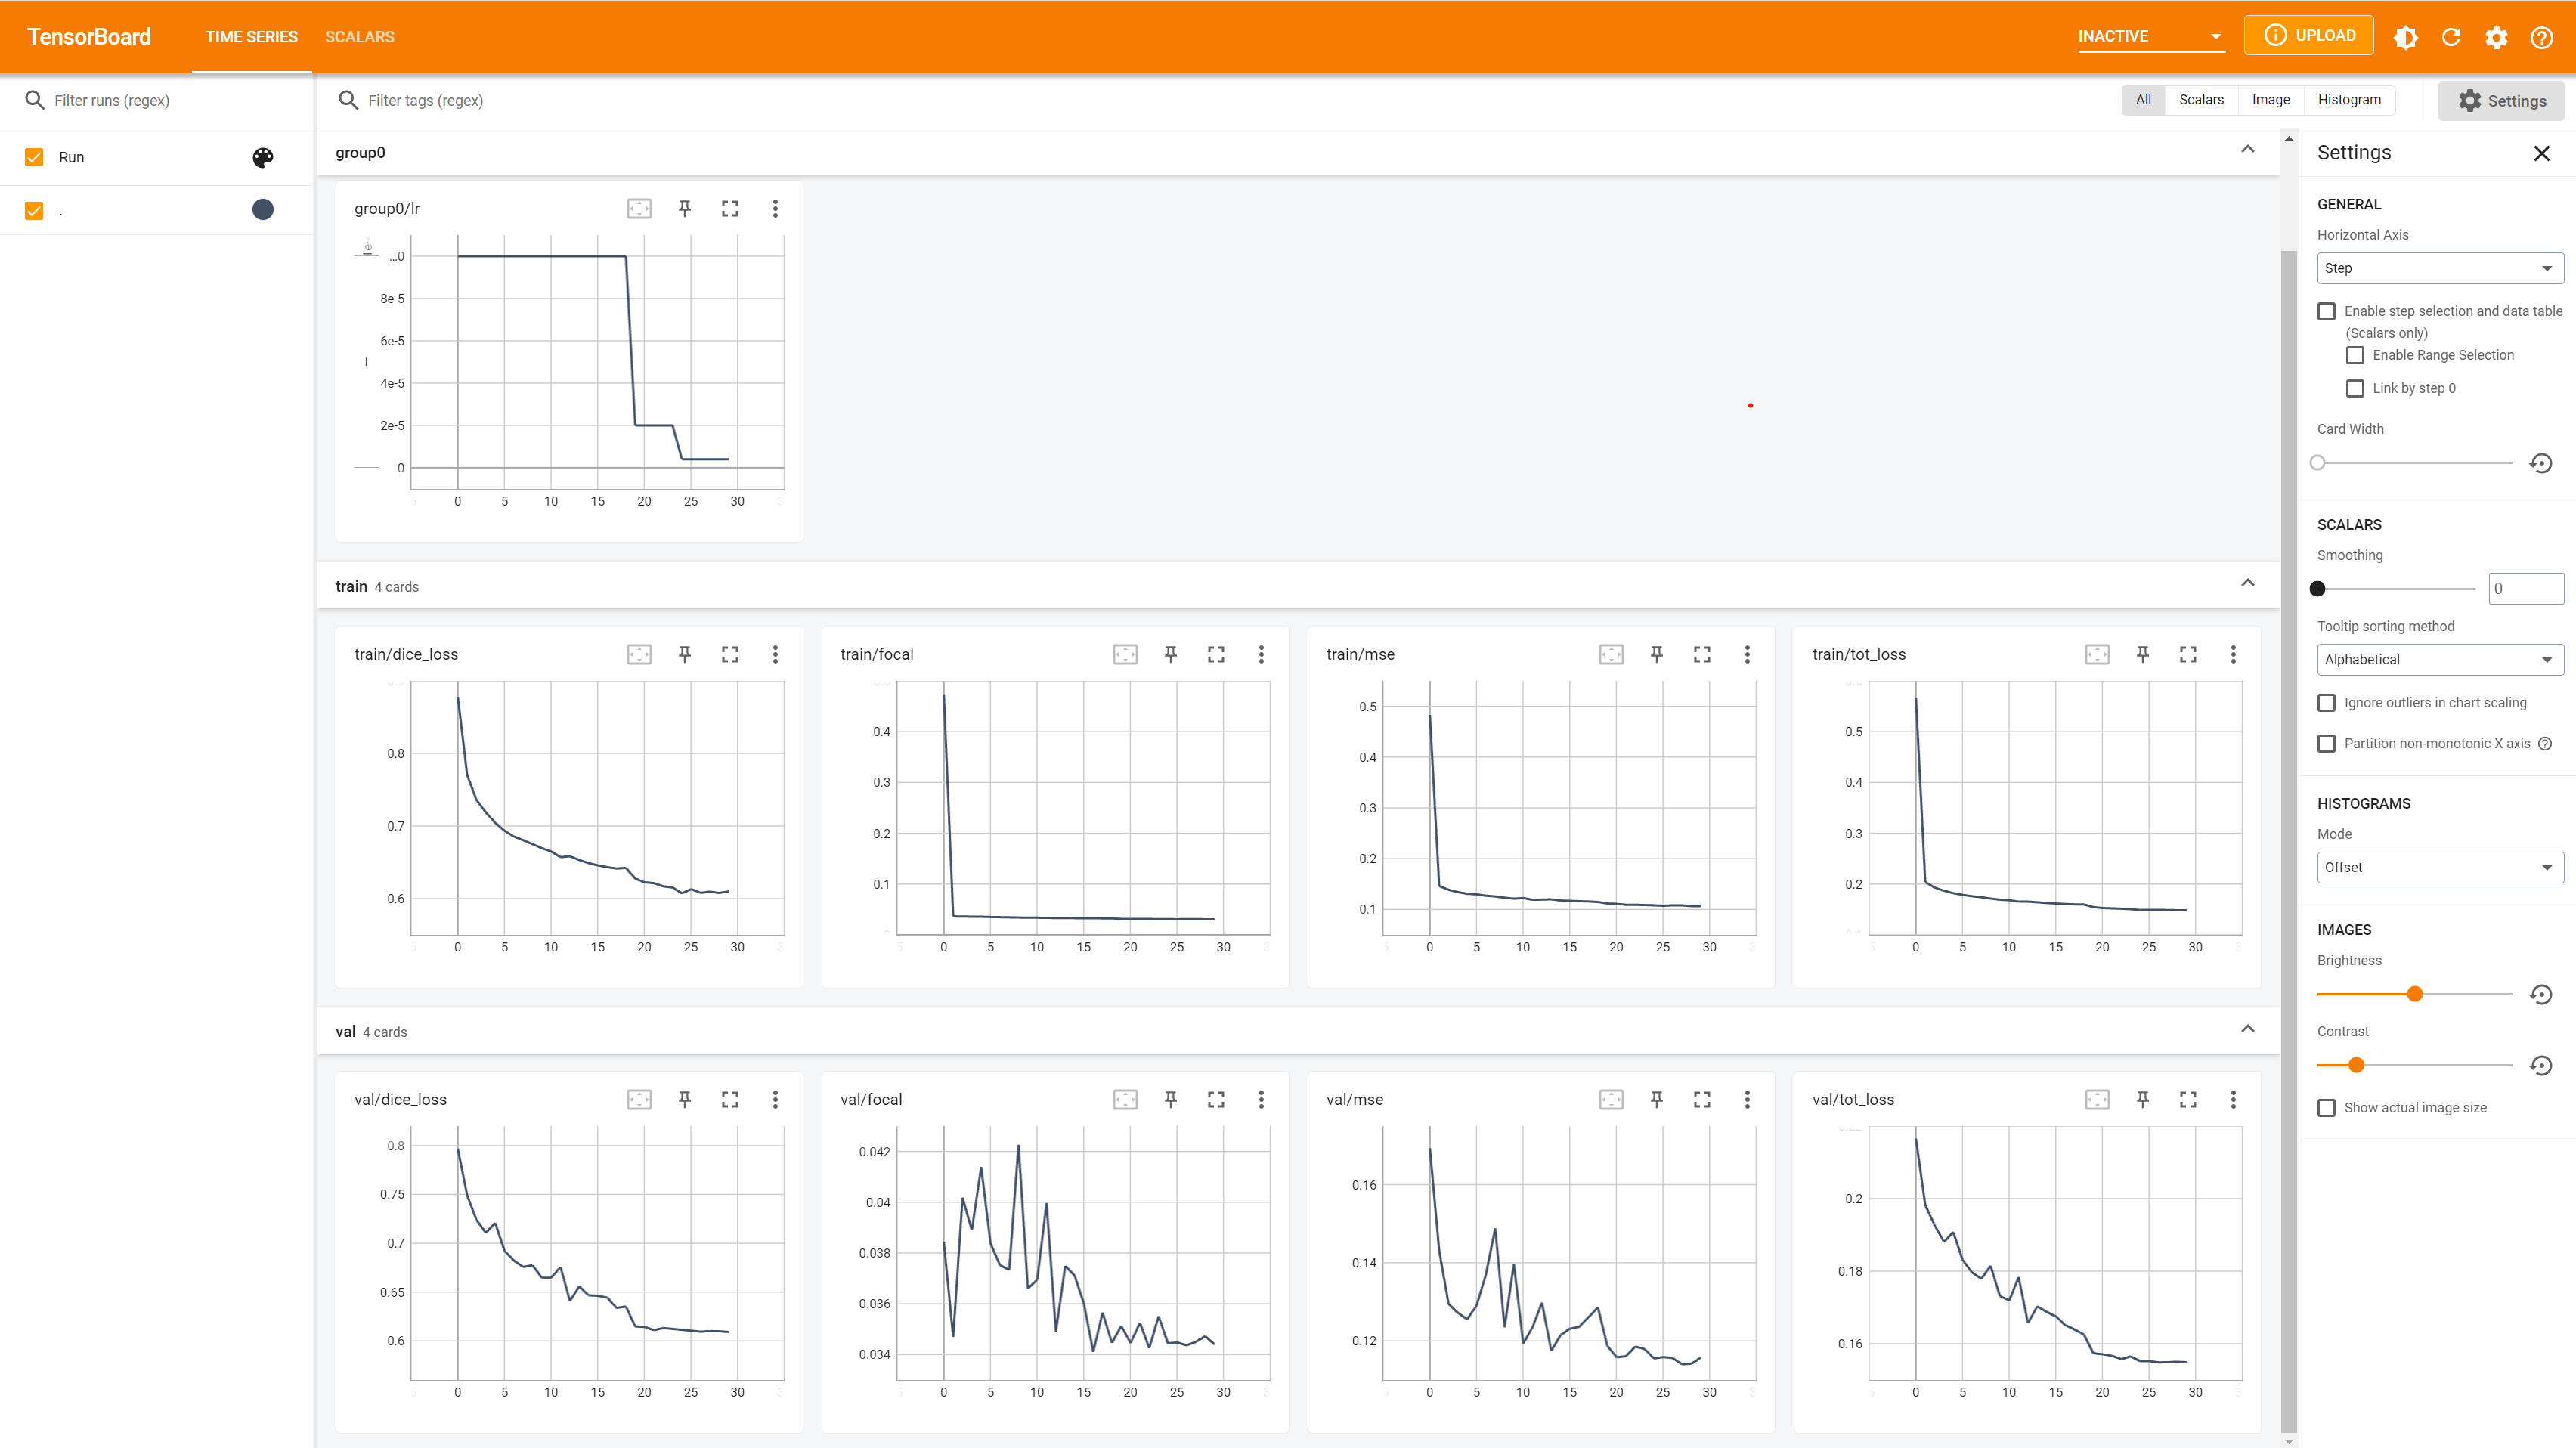



 

**Training Run Results**
- Each training epoch took only around 30 minutes to run. 
- The total training over 29 epochs took around 14.5 hours to run.

# Inference

To run inference, we can use the `02_eval.py` script (https://github.com/avanetten/cresi/blob/main/cresi/02_eval.py). Remember that we did modify a few lines to accomodate AMX and BF16 (see Codebase Changes above).

```
!python3 /home/devcloud/cresi/cresi/02_eval.py /home/devcloud/cresi/cresi/configs/ben/v5_sn5_baseline_ben.json
```

In [76]:
img_path = '/home/devcloud/spacenet5data/moscow/results_xeon4_devcloud/sn5_baseline/folds/fold0_SN5_roads_train_AOI_7_Moscow_PS-MS_chip994.tif'

Here is a sample mask output that was predicted.

mask_pred.shape: (8, 1300, 1300)


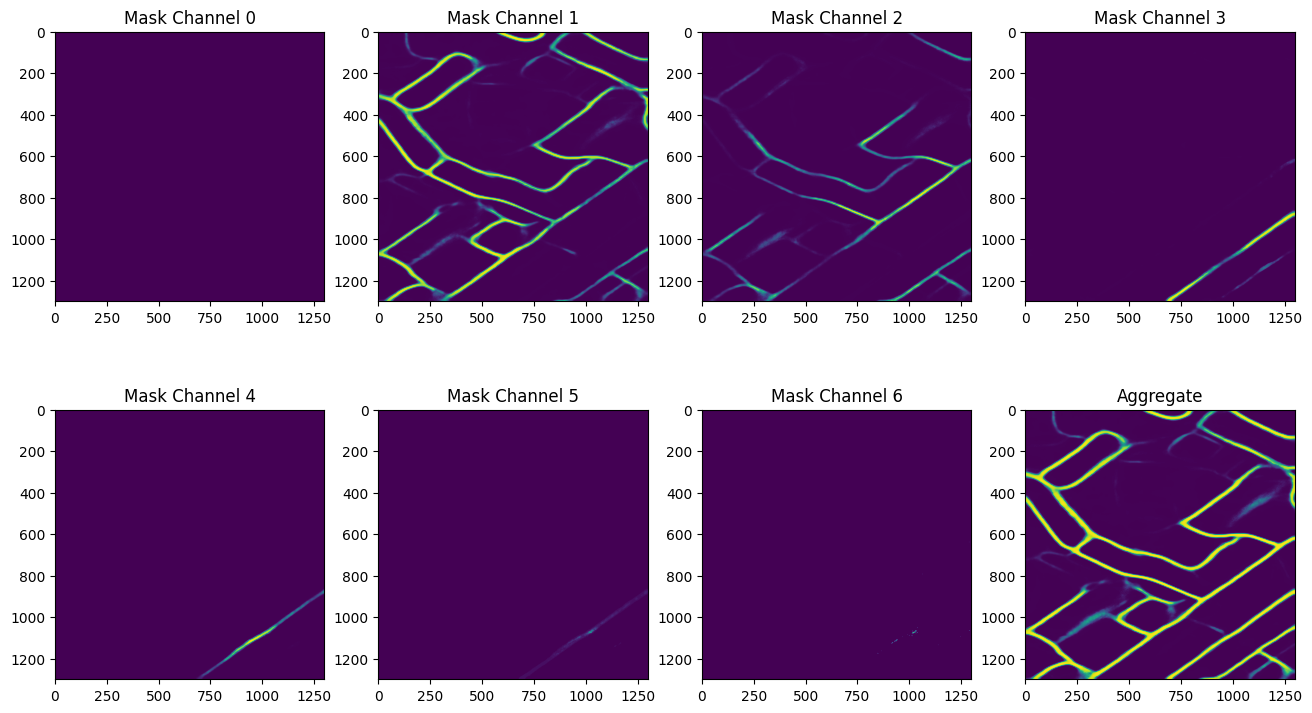

In [77]:
# inspect

mask_pred = skimage.io.imread(img_path)
print("mask_pred.shape:", mask_pred.shape)

# plot all layers
fig, axes = plt.subplots(2, 4, figsize=(16, 9))
for i, ax in enumerate(axes.flatten()):
    if i < (len(axes.flatten()) - 1):
        title = 'Mask Channel {}'.format(str(i))
    else:
        title = 'Aggregate' 
    ax.imshow(mask_pred[i,:,:])
    ax.set_title(title)

Here is the original image, the mask aggregate prediction, and the ground truth mask:

Text(0.5, 1.0, 'Ground Truth label chip 994')

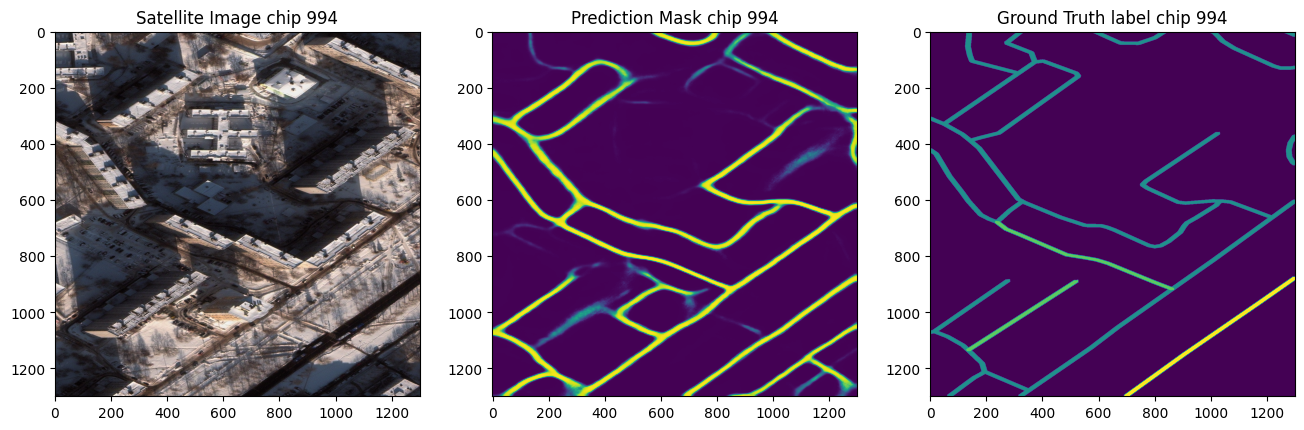

In [132]:
full_path_image = '/home/devcloud/spacenet5data/moscow/data/PS-RGB/SN5_roads_train_AOI_7_Moscow_PS-RGB_chip994.tif'
full_path_mask = '/home/devcloud/spacenet5data/moscow/results_xeon4_devcloud/sn5_baseline/folds/fold0_SN5_roads_train_AOI_7_Moscow_PS-MS_chip994.tif'
ground_truth_mask = '/home/devcloud/spacenet5data/moscow/data/v5/train_mask_binned_rename_rgb/SN5_roads_train_AOI_7_Moscow_PS-RGB_chip994.tif'

image_names = ['SN5_roads_train_AOI_7_Moscow_PS-RGB_chip994.tif','fold0_SN5_roads_train_AOI_7_Moscow_PS-MS_chip994.tif','SN5_roads_train_AOI_7_Moscow_PS-RGB_chip994.tif']

img1 = skimage.io.imread(full_path_image)
img2 = skimage.io.imread(full_path_mask)[7,:,:]
img3 = skimage.io.imread(ground_truth_mask)

f, axarr = plt.subplots(1,3,figsize=(16, 9))
axarr[0].imshow(img1)
axarr[0].set_title('Satellite Image chip 994')
axarr[1].imshow(img2)
axarr[1].set_title('Prediction Mask chip 994')
axarr[2].imshow(img3)
axarr[2].set_title('Ground Truth label chip 994')



In [129]:
np.unique(img3)

array([  0,  72, 108, 144], dtype=uint8)

**Merge, stitch, skeletonize** <br>
You can read more about the post-processing steps here:
- [The SpaceNet 5 Baseline — Part 3: Extracting Road Speed Vectors from Satellite Imagery](https://medium.com/the-downlinq/the-spacenet-5-baseline-part-3-extracting-road-speed-vectors-from-satellite-imagery-5d07cd5e1d21)

The outputs are quite long, and so I recommend doing these in a separate terminal (tmux)
```bash
python3 /home/devcloud/cresi/cresi/03a_merge_preds.py /home/devcloud/cresi/cresi/configs/ben/v5_sn5_baseline_ben.json
python3 /home/devcloud/cresi/cresi/03b_stitch.py /home/devcloud/cresi/cresi/configs/ben/v5_sn5_baseline_ben.json
python3 /home/devcloud/cresi/cresi/04_skeletonize.py /home/devcloud/cresi/cresi/configs/ben/v5_sn5_baseline_ben.json
python3 /home/devcloud/cresi/cresi/05_wkt_to_G.py /home/devcloud/cresi/cresi/configs/ben/v5_sn5_baseline_ben.json
```

# Recap
Today, we:
- Created 1352 speed-limit image training masks to correspond to our training satellite image data
- Defined our configuration file for training
- Split up our training and validation data
- Optimized our code for CPU training, including using Intel Extension for PyTorch and BF16
- Trained a ResNet34 model on a CPU in ~14 hours for 29 epochs
- Ran initial inference to see the prediction of a speed limit mask


Please let me know if you used the code here. And you can clone the Intel Extension for PyTorch from here:

https://github.com/intel/intel-extension-for-pytorch
